# Transverse deformation due to toroidal bending

This notebook goes a bit deeper in to the deformation fields due to toroidal bending than is needed for the usual usage of _tbcalc_. The examples presented here can be useful for somebody who wants to understand the theory behind _tbcalc_ better or maybe want to utilize it _e.g._ in optical simulations.

In [1]:
import sys
import os.path

import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(1, '..')
from tbcalc import Analyser, Quantity

## Circular wafer

In [2]:
kwargs = {
         'crystal'   : 'Si',
         'hkl'       : [6,6,0],
         'thickness' : Quantity(150,'um'),
         'R'         : Quantity(1, 'm'),
         'diameter'  : Quantity(100,'mm'),
         }

analyser = Analyser(**kwargs)

The stress and strain tensors, and the contact force can now be obtained with `Analyser.calculate_deformation()`.

In [3]:
stress, strain, contact_force = analyser.calculate_deformation(length_unit = 'mm', pressure_unit = 'MPa')

### Stress tensor and contact force

The stress tensor and contact force between the wafer and the substrate are rarely needed in the diffraction calculations but are important considering the mechanical integrity of a TBCA. It should be noted, however, that the transverse stress tensor is does not give a complete description of the internal stresses since it does not include the contribution from pure bending.

Stress tensor components are given in a dictionary whose keys are the indices of the tensor. Each component is a function of position on the wafer surface. Coordinates outside the wafer return `nan`.

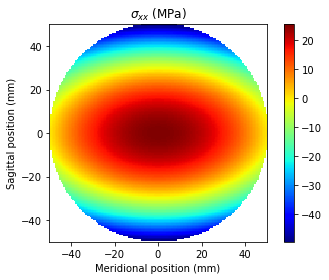

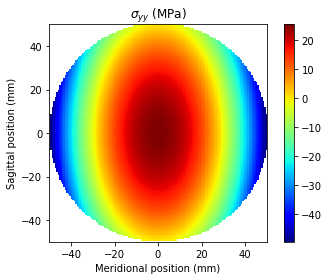

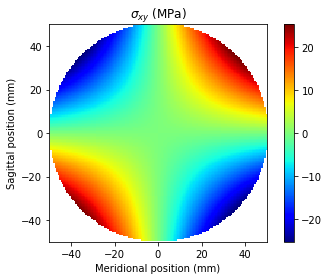

In [4]:
x = np.linspace(-50,50,150) 
X,Y = np.meshgrid(x,x)

for ij in ['xx','yy','xy']:
    plt.figure()
    plt.axes().set_aspect('equal')
    plt.pcolormesh(X,Y,stress[ij](X,Y),cmap='jet')
    plt.title('$\sigma_{'+ij+'}$ (MPa)')
    plt.colorbar()
    plt.xlabel('Meridional position (mm)')
    plt.ylabel('Sagittal position (mm)')

The stresses can be indexed with integers as well. In the example below we calculate the von Mises stress, which can be used to estimate the yield criterion of the wafer, and is given by
$$
\sigma_v = \sqrt{\sigma_{11}^2 - \sigma_{11} \sigma_{22} + \sigma_{22}^2 + 3 \sigma_{12}^2}.
$$

(Again, this applies for a very thin wafer since the contribution due to the pure bending part is not included in the transverse stress tensor.)

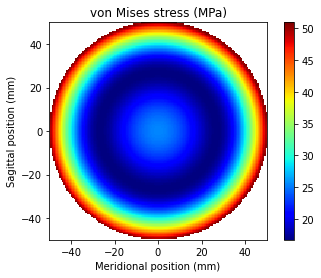

In [5]:
plt.figure()
plt.axes().set_aspect('equal')
plt.pcolormesh(X,Y,np.sqrt(stress[11](X,Y)**2 - stress[11](X,Y)*stress[22](X,Y) + stress[22](X,Y)**2 + 3*stress[12](X,Y)**2),cmap='jet')
plt.title('von Mises stress (MPa)')
plt.colorbar()
plt.xlabel('Meridional position (mm)')
plt.ylabel('Sagittal position (mm)')
plt.show()

The contact force per unit area is also given as a function of position but, unlike the stress tensor, it is only a single function. The negative value indicates that the contact force pulls the wafer against the substrate and the positive pushes it away.

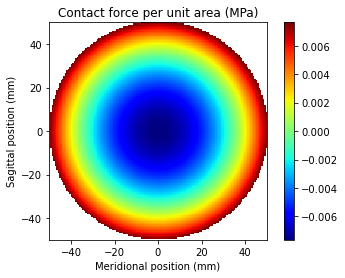

In [6]:
plt.figure()
plt.axes().set_aspect('equal')
plt.pcolormesh(X,Y,contact_force(X,Y),cmap='jet')
plt.title('Contact force per unit area (MPa)')
plt.colorbar()
plt.xlabel('Meridional position (mm)')
plt.ylabel('Sagittal position (mm)')
plt.show()

### Strain tensor and cylindrical coordinates

Strain tensor is similar to the stress tensor except for the fact that it has additional components as the transverse stress causes deformation also in the $z$-direction.

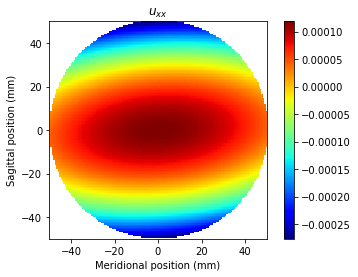

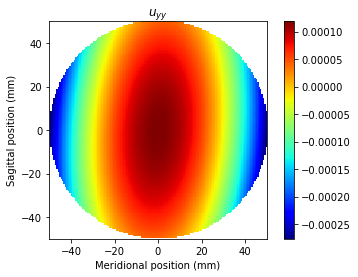

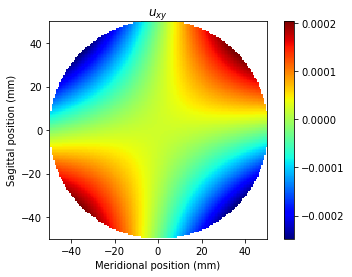

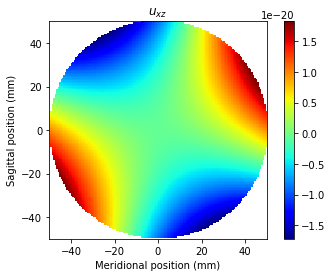

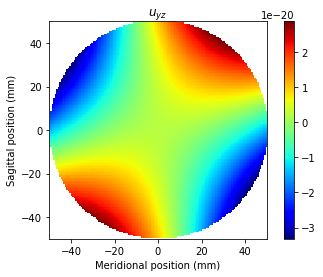

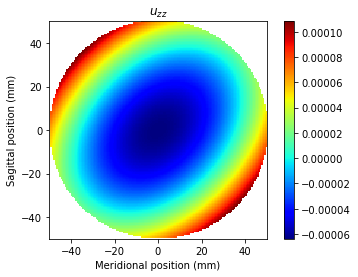

In [7]:
x = np.linspace(-50,50,150) 
X,Y = np.meshgrid(x,x)

for ij in ['xx','yy','xy','xz','yz','zz']:
    plt.figure()
    plt.axes().set_aspect('equal')
    plt.pcolormesh(X,Y,strain[ij](X,Y),cmap='jet')
    plt.title('$u_{'+ij+'}$')
    plt.colorbar()
    plt.xlabel('Meridional position (mm)')
    plt.ylabel('Sagittal position (mm)')

Note that unlike the stress tensor, the isocurves of the strain tensor components are not oriented along the coordinate axes (caused by the non-diagonal components of the compliance matrix).

Sometimes, especially with the circular wafers, it maybe useful to examine the components presented in the cylindrical coordinates. A function is provided for the coordinate transform:

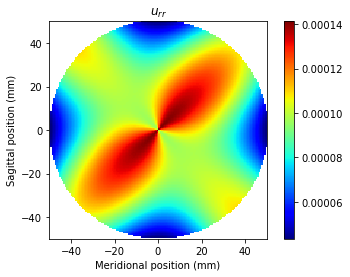

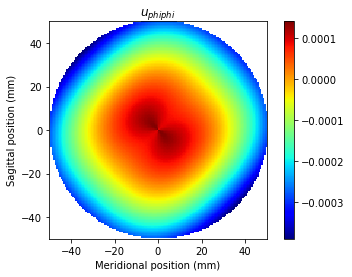

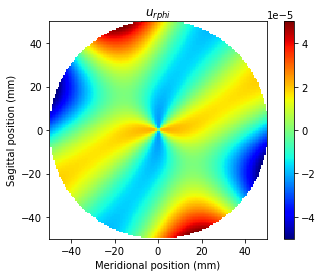

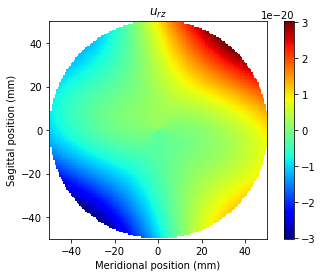

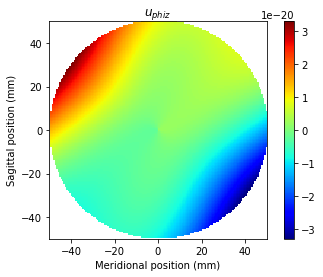

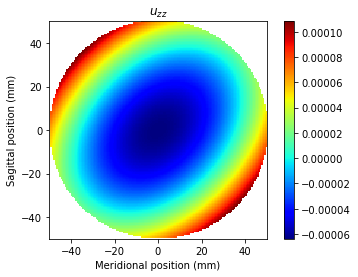

In [8]:
from tbcalc import cartesian_tensors_to_cylindrical

strain_cyl = cartesian_tensors_to_cylindrical(strain)

RR = np.sqrt(X**2 + Y**2)
PHI = np.arctan2(Y,X)

for ij in ['rr','phiphi','rphi','rz','phiz','zz']:
    plt.figure()
    plt.axes().set_aspect('equal')
    plt.pcolormesh(X,Y,strain_cyl[ij](RR,PHI),cmap='jet')
    plt.title('$u_{'+ij+'}$')
    plt.colorbar()
    plt.xlabel('Meridional position (mm)')
    plt.ylabel('Sagittal position (mm)')

plt.show()

### Energy and angle shifts

`Analyser` implements functions which wrap all the required strain tensor components into a single function that returns the shifts in the diffraction energy or angle as function of position. In the following example, the energy shifts are calculated and their distribution is compared to the analytical expression presented in the manuscript.

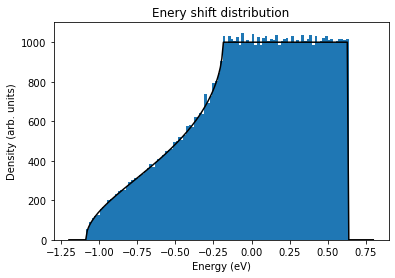

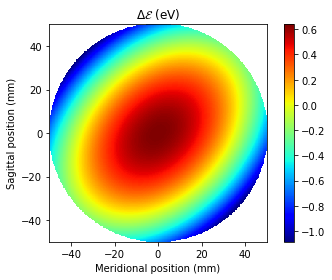

In [9]:
E0 = Quantity(10,'keV') #Energy of incident photons

energy_shift = analyser.energy_shifts(E0,length_unit = 'mm') #Bragg angle could be used as well instead of energy

#Surface coordinates
x = np.linspace(-50,50,300) 
X,Y = np.meshgrid(x,x)

dE = energy_shift(X,Y).in_units('eV')

#Plot the distribution of energy shifts
plt.hist(dE[np.logical_not(np.isnan(dE))].reshape(-1),bins=100)

#compare to the analytical expression
def dE_dist_circular(denergy,E0):
    S = analyser.crystal_object.S.in_units('GPa^-1')
    L = analyser.geometry_info['diameter'].in_units('m')
    R = np.sqrt(analyser.crystal_object.Rx.in_units('m')*analyser.crystal_object.Ry.in_units('m'))
    
    Eeff = 8/(3*(S[0,0] + S[1,1]) + 2*S[0,1] + S[5,5])
    A = -(S[2,0] + S[2,1])*Eeff*L**2/(64*R**2)*E0.in_units('eV')
    B = Eeff*L**2/(64*R**2)*E0.in_units('eV')*np.sqrt((S[2,0] - S[2,1])**2 + S[2,5]**2)

    out = np.zeros(denergy.shape)
    ind = np.logical_and(denergy > -A-B, denergy < -A+B)
    out[ind] = np.arctan(np.sqrt((B-2*A)*(denergy[ind]+A+B)/(B+2*A)/(denergy[ind]+A-B)))/np.pi*2
    out[np.logical_and(denergy < A,denergy > -A+B)] = 1

    return out

de = np.linspace(-1.2,0.8,200)
plt.plot(de,dE_dist_circular(de,E0)*1000,'k')
plt.xlabel('Energy (eV)')
plt.ylabel('Density (arb. units)')
plt.title('Enery shift distribution')

plt.figure()
plt.axes().set_aspect('equal')
plt.pcolormesh(X,Y,energy_shift(X,Y).in_units('eV'),cmap='jet')
plt.title('$\Delta \mathcal{E}$ (eV)')
plt.colorbar()
plt.xlabel('Meridional position (mm)')
plt.ylabel('Sagittal position (mm)')

plt.show()

The shifts in the rocking angle scan are obtained analogously:

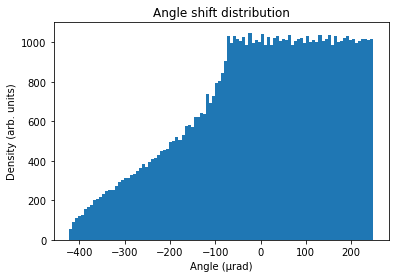

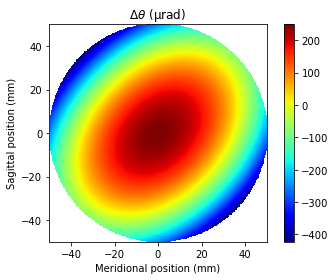

In [10]:
E0 = Quantity(10,'keV') #Energy of incident photons

angle_shift = analyser.angle_shifts(E0,length_unit = 'mm') #Bragg angle could be used as well instead of energy

#Surface coordinates
x = np.linspace(-50,50,300) 
X,Y = np.meshgrid(x,x)

dth = angle_shift(X,Y).in_units('urad')

#Plot the distribution of energy shifts
plt.hist(dth[np.logical_not(np.isnan(dth))].reshape(-1),bins=100)
plt.xlabel(u'Angle (µrad)')
plt.ylabel('Density (arb. units)')
plt.title('Angle shift distribution')

plt.figure()
plt.axes().set_aspect('equal')
plt.pcolormesh(X,Y,angle_shift(X,Y).in_units('urad'),cmap='jet')
plt.title(u'$\Delta \\theta$ (µrad)')
plt.colorbar()
plt.xlabel('Meridional position (mm)')
plt.ylabel('Sagittal position (mm)')

plt.show()


## Rectangular wafer

For the sake of interest, the strain and stress tensor components are plotted below for a rectangular wafer.

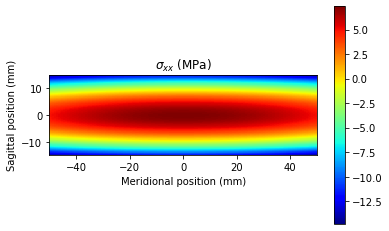

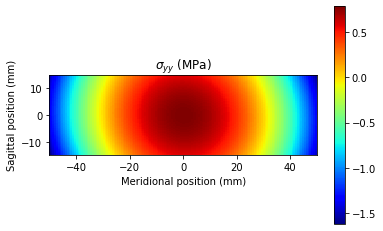

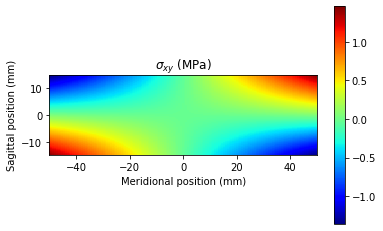

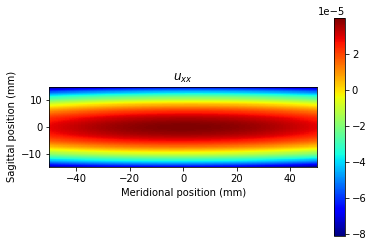

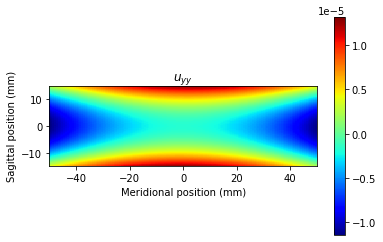

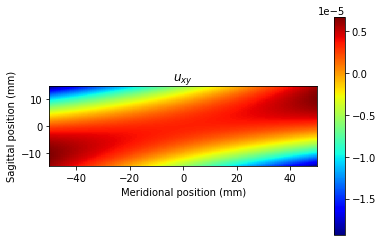

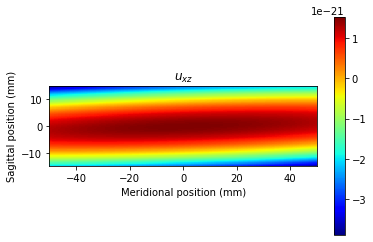

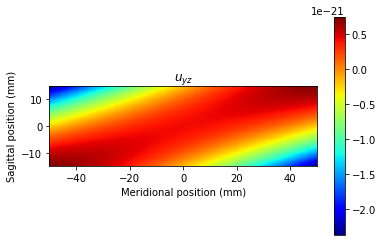

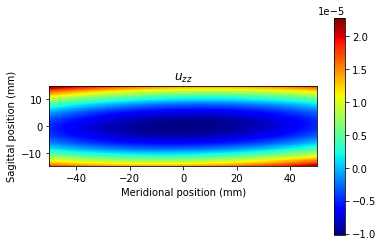

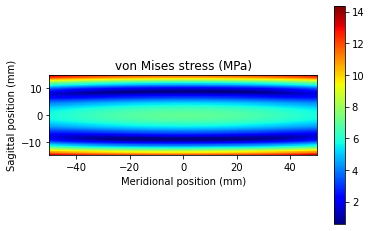

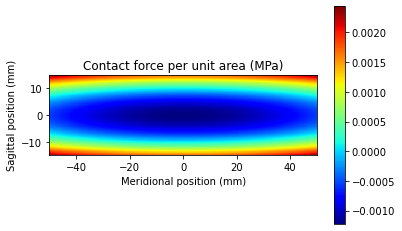

In [11]:
kwargs = {
         'crystal'   : 'Si',
         'hkl'       : [6,6,0],
         'thickness' : Quantity(150,'um'),
         'R'         : Quantity(1, 'm'),
         'a'  : Quantity(100,'mm'),
         'b'  : Quantity(30,'mm'),
}

analyser = Analyser(**kwargs)
stress, strain, contact_force = analyser.calculate_deformation(length_unit = 'mm', pressure_unit = 'MPa')

x = np.linspace(-50,50,150)
y = np.linspace(-15,15,150) 
X,Y = np.meshgrid(x,y)

for ij in ['xx','yy','xy']:
    plt.figure()
    plt.axes().set_aspect('equal')
    plt.pcolormesh(X,Y,stress[ij](X,Y),cmap='jet')
    plt.title('$\sigma_{'+ij+'}$ (MPa)')
    plt.colorbar()
    plt.xlabel('Meridional position (mm)')
    plt.ylabel('Sagittal position (mm)')

for ij in ['xx','yy','xy','xz','yz','zz']:
    plt.figure()
    plt.axes().set_aspect('equal')
    plt.pcolormesh(X,Y,strain[ij](X,Y),cmap='jet')
    plt.title('$u_{'+ij+'}$')
    plt.colorbar()
    plt.xlabel('Meridional position (mm)')
    plt.ylabel('Sagittal position (mm)')
    
plt.figure()
plt.axes().set_aspect('equal')
plt.pcolormesh(X,Y,np.sqrt(stress[11](X,Y)**2 - stress[11](X,Y)*stress[22](X,Y) + stress[22](X,Y)**2 + 3*stress[12](X,Y)**2),cmap='jet')
plt.title('von Mises stress (MPa)')
plt.colorbar()
plt.xlabel('Meridional position (mm)')
plt.ylabel('Sagittal position (mm)')

plt.figure()
plt.axes().set_aspect('equal')
plt.pcolormesh(X,Y,contact_force(X,Y),cmap='jet')
plt.title('Contact force per unit area (MPa)')
plt.colorbar()
plt.xlabel('Meridional position (mm)')
plt.ylabel('Sagittal position (mm)')

plt.show()    

Below we calculate the energy shifts. Because there is no analytical expression for the anisotropic rectangular case, the calculation is performed for an isotropic wafer instead.

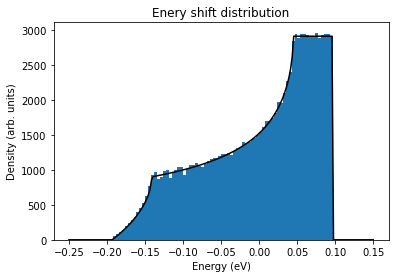

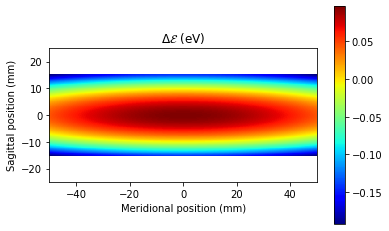

In [12]:
kwargs = {
         'crystal'   : 'Si',
         'hkl'       : [6,6,0],
         'thickness' : Quantity(150,'um'),
         'R'         : Quantity(1, 'm'),
         'a'  : Quantity(100,'mm'),
         'b'  : Quantity(30,'mm'),
         'E'  : Quantity(165,'GPa'),
         'nu'  : 0.22,
}

analyser = Analyser(**kwargs)

E0 = Quantity(9.8,'keV')
energy_shift = analyser.energy_shifts(E0,length_unit = 'mm')

x = np.linspace(-50,50,600)
y = np.linspace(-25,25,300)
X,Y = np.meshgrid(x,y)

dE = energy_shift(X,Y).in_units('eV')

#Plot the distribution of energy shifts
plt.hist(dE[np.logical_not(np.isnan(dE))].reshape(-1),bins=75)

#compare to the analytical expression
def dE_dist_rectangular(denergy,E0):
    nu = analyser.crystal_object.nu
    
    a = analyser.geometry_info['a'].in_units('m')
    b = analyser.geometry_info['b'].in_units('m')
    if a > b:
        temp = a
        a = b
        b = temp
        
    R = np.sqrt(analyser.crystal_object.Rx.in_units('m')*analyser.crystal_object.Ry.in_units('m'))
    
    g = 8 + 10*(a**2/b**2 + b**2/a**2) + (1-nu)*(a**2/b**2 - b**2/a**2)**2
    
    A = nu/(g*R**2)*((3+nu)/2 + 5*b**2/a**2 + (1-nu)/2*b**4/a**4)*E0.in_units('eV')
    B = nu/(g*R**2)*((3+nu)/2 + 5*a**2/b**2 + (1-nu)/2*a**4/b**4)*E0.in_units('eV')
    C = (A*a**2 + B*b**2)/12

    out = np.zeros(denergy.shape)

    ind1 = np.logical_and(denergy > -(A*a**2+B*b**2)/6, denergy < -(2*A*a**2-B*b**2)/12)
    ind2 = np.logical_and(denergy > -(2*A*a**2-B*b**2)/12, denergy < (A*a**2-2*B*b**2)/12)
    ind3 = np.logical_and(denergy > (A*a**2-2*B*b**2)/12, denergy < (A*a**2+B*b**2)/12)

    out[ind1] = 1 - np.arctan(np.sqrt(4*(C-denergy[ind1])/(B*b**2)-1))/np.pi*2 - np.arctan(np.sqrt(4*(C-denergy[ind1])/(A*a**2)-1))/np.pi*2       
    out[ind2] = 1 - np.arctan(np.sqrt(4*(C-denergy[ind2])/(B*b**2)-1))/np.pi*2
    out[ind3] = 1

    return out

de = np.linspace(-0.25,0.15,200)
plt.plot(de,dE_dist_rectangular(de,E0)*2910,'k')
plt.xlabel('Energy (eV)')
plt.ylabel('Density (arb. units)')
plt.title('Enery shift distribution')

plt.figure()
plt.axes().set_aspect('equal')
plt.pcolormesh(X,Y,energy_shift(X,Y).in_units('eV'),cmap='jet')
plt.title('$\Delta \mathcal{E}$ (eV)')
plt.colorbar()
plt.xlabel('Meridional position (mm)')
plt.ylabel('Sagittal position (mm)')

plt.show()

## Strip-bent analyser

In [13]:
kwargs = {
         'crystal'     : 'Si',
         'hkl'         : [6,6,0],
         'thickness'   : Quantity(150,'um'),
         'R'           : Quantity(1, 'm'),
         'diameter'    : Quantity(100,'mm'),
         'strip_width' : Quantity(15,'mm'),
         'lateral_strips': 'narrow',
         'center_strip': True,
         'strip_orientation': 'meridional',
}

analyser = Analyser(**kwargs)

stress, strain, contact_force = analyser.calculate_deformation(length_unit = 'mm', pressure_unit = 'MPa')

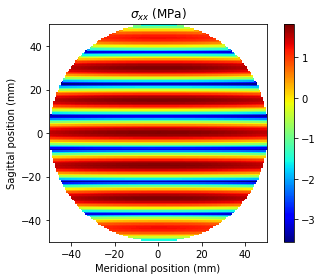

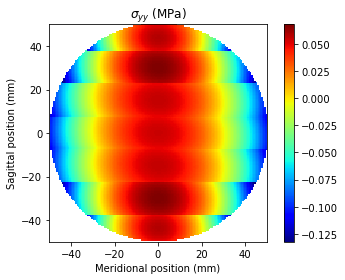

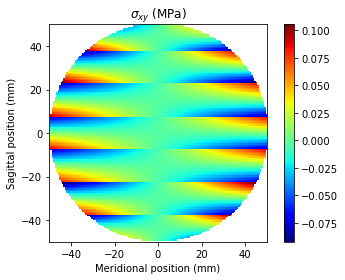

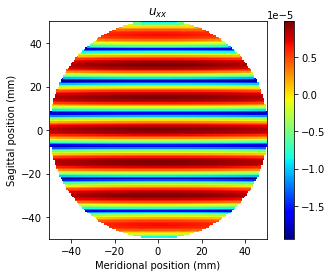

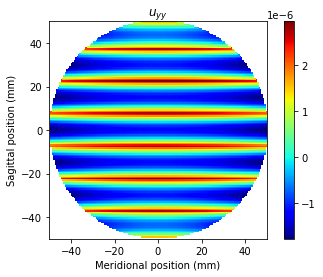

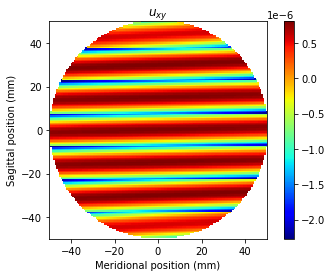

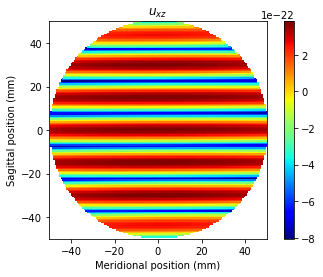

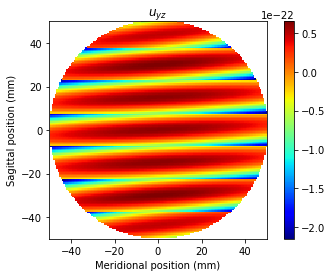

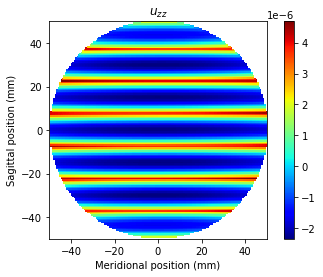

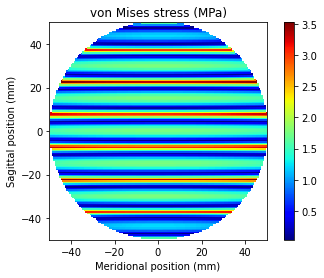

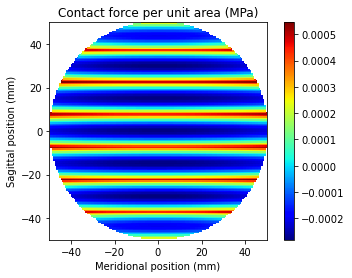

In [14]:
x = np.linspace(-50,50,150)
y = np.linspace(-50,50,150) 
X,Y = np.meshgrid(x,y)

for ij in ['xx','yy','xy']:
    plt.figure()
    plt.axes().set_aspect('equal')
    plt.pcolormesh(X,Y,stress[ij](X,Y),cmap='jet')
    plt.title('$\sigma_{'+ij+'}$ (MPa)')
    plt.colorbar()
    plt.xlabel('Meridional position (mm)')
    plt.ylabel('Sagittal position (mm)')

for ij in ['xx','yy','xy','xz','yz','zz']:
    plt.figure()
    plt.axes().set_aspect('equal')
    plt.pcolormesh(X,Y,strain[ij](X,Y),cmap='jet')
    plt.title('$u_{'+ij+'}$')
    plt.colorbar()
    plt.xlabel('Meridional position (mm)')
    plt.ylabel('Sagittal position (mm)')
    
plt.figure()
plt.axes().set_aspect('equal')
plt.pcolormesh(X,Y,np.sqrt(stress[11](X,Y)**2 - stress[11](X,Y)*stress[22](X,Y) + stress[22](X,Y)**2 + 3*stress[12](X,Y)**2),cmap='jet')
plt.title('von Mises stress (MPa)')
plt.colorbar()
plt.xlabel('Meridional position (mm)')
plt.ylabel('Sagittal position (mm)')

plt.figure()
plt.axes().set_aspect('equal')
plt.pcolormesh(X,Y,contact_force(X,Y),cmap='jet')
plt.title('Contact force per unit area (MPa)')
plt.colorbar()
plt.xlabel('Meridional position (mm)')
plt.ylabel('Sagittal position (mm)')

plt.show()    